In [ ]:
#| hide

%load_ext autoreload
%autoreload 2

# Graph alignment

> Using DiffPaSS to align two graphs.

**Note**: This notebook requires `networkx`.

In [ ]:
# Stdlib imports
from typing import Optional

# NumPy
import numpy as np

# PyTorch
import torch

# Plotting
from matplotlib import pyplot as plt

# NetworkX
import networkx as nx

# Set the number of threads for PyTorch
torch.set_num_threads(8)

# Device
DEVICE = torch.device(
    f"cuda{(':' + input('Enter the CUDA device number:')) if torch.cuda.device_count() > 1 else ''}"
    if torch.cuda.is_available() else "cpu"
)
# DEVICE = torch.device("cpu")
print(f"Using device: {DEVICE}")

# Set the seeds for NumPy and PyTorch
NUMPY_SEED = 42
np.random.seed(NUMPY_SEED)

TORCH_SEED = 42
torch.manual_seed(TORCH_SEED);

NX_SEED = 42

Using device: cuda


## 1. Create the adjacency matrices of two SBM graphs

We create two SBM graphs with a few communities of equal size. We then randomly permute the nodes in one of the graphs to create the second graph. The Laplacian matrices of these graphs are used as inputs for `diffpass.train.GraphAlignment`.

In [ ]:
def create_test_sbm_laplacian(
    block_sizes: list ,
    block_prob: list,
):
    """Create a stochastic block model graph with given block sizes and block probabilities. Return its dense Laplacian matrix."""
    g = nx.stochastic_block_model(block_sizes, block_prob, seed=NX_SEED)
    g.remove_nodes_from(list(nx.isolates(g)))
    n = len(g)
    # Laplacian matrix
    l = nx.laplacian_matrix(g, range(n))

    return torch.tensor(
        l.todense(), dtype=torch.get_default_dtype(), device=DEVICE
    )

# Create an SBM graph with `n_blocks` communities of equal size
n_nodes = 40
n_blocks = 4
block_sizes = [int(n_nodes / n_blocks)] * n_blocks
inter = 0.3
intra = 0.7
probs = [
    [intra, inter, inter, inter],
    [inter, intra, inter, inter],
    [inter, inter, intra, inter],
    [inter, inter, inter, intra]
]

# Create the Laplacian matrix of the first graph
x = create_test_sbm_laplacian(block_sizes, probs)
n_nodes = len(x)  # In case the number of nodes has changed due to removal of isolates

# Define the second graph by randomly permuting the nodes in the first
P = torch.zeros_like(x)
P[torch.arange(n_nodes), torch.randperm(n_nodes)] = 1
y = P @ x @ P.T

## 2. Align the graphs by maximising the dot product between the Laplacian matrices: `GraphAlignment`

The default behaviour of `GraphAlignment` is to maximise the dot product between the upper triangles (including or excluding the main diagonal) of two input square matrices. The `GraphAlignment` class also allows for custom comparison losses to be used, but we do not do so in this example

In [ ]:
from diffpass.train import GraphAlignment, IntraGroupSimilarityLoss

group_sizes = [n_nodes]
comparison_loss = IntraGroupSimilarityLoss(
    group_sizes=group_sizes, exclude_diagonal=False
)  # Default behaviour except for inclusion of the main diagonal

# Initialize the GraphAlignment model
graph_alignment = GraphAlignment(
    group_sizes=group_sizes,
    comparison_loss=comparison_loss
).to(DEVICE)

In [ ]:
# Optimization parameters for DiffPaSS bootstrap
bootstrap_cfg = {
    "n_start": 1,
    "n_end": None,
    "step_size": 1,  # Increase to speed up if needed
    "show_pbar": True,
    "single_fit_cfg": None  # Default
}

# Run the DiffPaSS bootstrap
bootstrap_results = graph_alignment.fit_bootstrap(x, y, **bootstrap_cfg)

100%|██████████| 38/38 [00:00<00:00, 252.12it/s]


## 3. Plot the resulting hard losses

In [ ]:
# Ground truth hard loss
target_hard_loss = graph_alignment.compute_losses_identity_perm(x, x)["hard"]

In [ ]:
def plot_hard_losses(
    results,
    target_hard_loss: Optional[float] = None
):
    hard_losses = [
        min(hard_losses_this_step)
        for hard_losses_this_step in results.hard_losses
    ]

    plt.plot(hard_losses, ".-", label="DiffPaSS hard permutation")
    plt.axhline(target_hard_loss, color="red", label=f"Ground truth loss (identity) = {target_hard_loss:.4f}")
    plt.ylabel("Hard loss")
    plt.xlabel("Bootstrap iteration")
    plt.title(f"Minimum loss during optimization: {np.min(hard_losses):.4f}")
    plt.legend()

    plt.show()

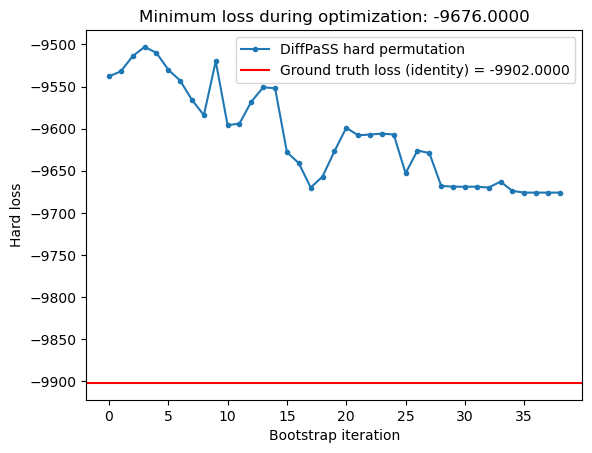

In [ ]:
plot_hard_losses(bootstrap_results, target_hard_loss=target_hard_loss)

The hard loss has been decreased, but is a far cry from the ground truth loss.

Can we do better?

## 4. Increase the number of repeats for each bootstrap iteration

We can use a "greedier" approach and further exploit the randomness in the bootstrap procedure. At each bootstrap iteration, instead of only performing a single gradient optimization, we can perform multiple optimizations -- each using a different, randomly sampled set of fixed pairs. We can then choose the one yielding the lowest hard loss.

This is done by setting `n_repeats` to a value greater than 1 in the `fit_bootstrap` method.

100%|██████████| 38/38 [00:13<00:00,  2.89it/s]


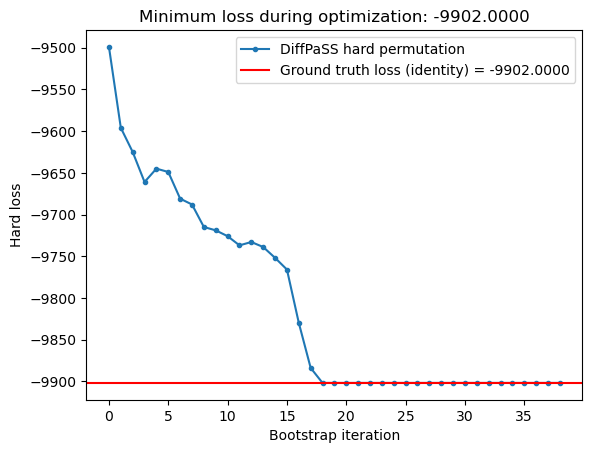

In [ ]:
bootstrap_cfg = {
    "n_start": 1,
    "n_end": None,
    "step_size": 1,  # Increase to speed up if needed
    "show_pbar": True,
    "single_fit_cfg": None,  # Default
    "n_repeats": 100  # Number of repeats for each bootstrap iteration -- increasing this should lead to better results
}

graph_alignment = GraphAlignment(
    group_sizes=group_sizes,
    comparison_loss=comparison_loss
).to(DEVICE)

bootstrap_results = graph_alignment.fit_bootstrap(x, y, **bootstrap_cfg)

plot_hard_losses(bootstrap_results, target_hard_loss=target_hard_loss)

Awesome! We have perfectly matched the hard loss given by the ground truth alignment!